In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import re
import string

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.style.use('seaborn-v0_8-whitegrid')

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report, roc_auc_score
from sklearn.inspection import permutation_importance

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from textblob import TextBlob
from wordcloud import WordCloud

import joblib

In [2]:
!ls /kaggle/input

spam-vs-ham-emails


In [3]:
data_path = "/kaggle/input/spam-vs-ham-emails"

#### Data Loading

In [4]:
data = pd.read_csv(os.path.join(data_path, "email_spam_dataset.csv"))
print(f"Data have: {data.shape[0]} rows and {data.shape[1]} columns")

Data have: 320 rows and 2 columns


#### Explore data

In [5]:
data.head()

,email_text,label
0,Here is the project update you asked for.,ham
1,Limited offer!!! Buy now and get 50% discount.,spam
2,Win cash prizes instantly by replying to this ...,spam
3,Urgent! Your account has been suspended. Verif...,spam
4,"Hi, please find the meeting agenda attached.",ham


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   email_text  320 non-null    object
 1   label       320 non-null    object
dtypes: object(2)
memory usage: 5.1+ KB


In [7]:
print("Missing values:\n", data.isnull().sum())

Missing values:
 email_text    0
label         0
dtype: int64


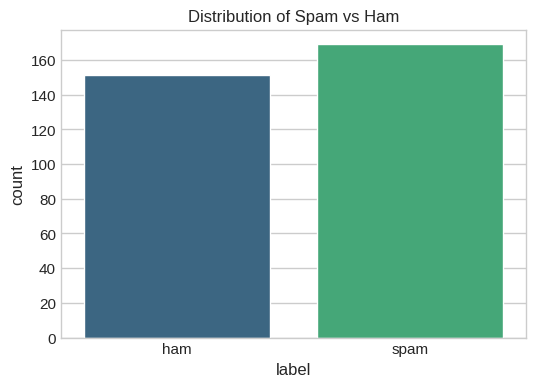

In [8]:
# Target Variable Distribution
plt.figure(figsize=(6, 4))
sns.countplot(hue='label', x='label', data=data, palette='viridis')
plt.title('Distribution of Spam vs Ham')
plt.show()

In [9]:
data['label'].value_counts(normalize=True)

label
spam    0.528125
ham     0.471875
Name: proportion, dtype: float64

### Observation: Target Distribution
The dataset shows the balance between 'spam' and 'ham' emails. Understanding this balance is crucial because a highly imbalanced dataset might require techniques like resampling (oversampling/undersampling) before modeling to prevent bias towards the majority class.

In [10]:
# Add length of email (character count)
data['length'] = data['email_text'].apply(len)

# Add word count
data['word_count'] = data['email_text'].apply(lambda x: len(x.split()))

# Count exclamation and question marks
data['emphatic_punctuation'] = data['email_text'].apply(lambda x: x.count('!') + x.count('?'))

# Ratio of uppercase letters
data['uppercase_ratio'] = data['email_text'].apply(lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0)

# Count numeric characters
data['numeric_count'] = data['email_text'].apply(lambda x: sum(1 for c in x if c.isdigit()))

data.head()

,email_text,label,length,word_count,emphatic_punctuation,uppercase_ratio,numeric_count
0,Here is the project update you asked for.,ham,41,8,0,0.024390,0
1,Limited offer!!! Buy now and get 50% discount.,spam,46,8,3,0.043478,2
2,Win cash prizes instantly by replying to this ...,spam,52,9,0,0.019231,0
3,Urgent! Your account has been suspended. Verif...,spam,60,8,1,0.050000,0
4,"Hi, please find the meeting agenda attached.",ham,44,7,0,0.022727,0


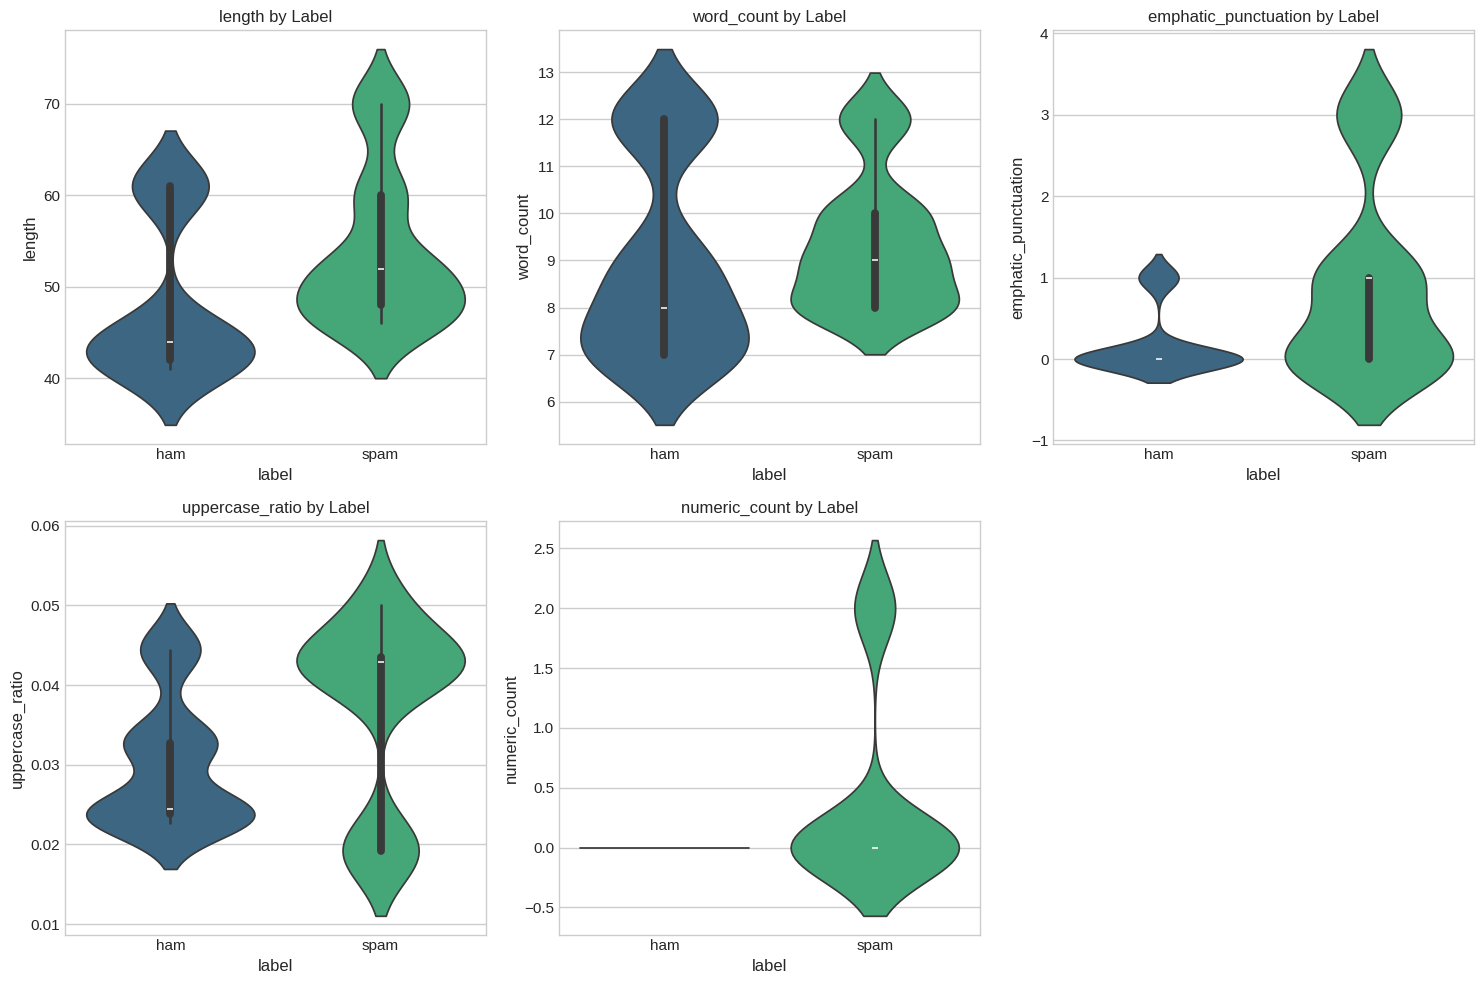

In [11]:
features = ['length', 'word_count', 'emphatic_punctuation', 'uppercase_ratio', 'numeric_count']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.violinplot(x='label', y=feature, data=data, palette='viridis', hue='label')
    plt.title(f'{feature} by Label')

plt.tight_layout()
plt.show()

### Observation: Features by Label
- **Length & Word Count**: Spam emails might show a different length distribution. Short, punchy messages or very long scams can be characteristic.
- **Emphatic Punctuation**: Spam emails tend to use significantly more exclamation and question marks to create urgency.
- **Uppercase Ratio**: A higher ratio of uppercase letters is a strong indicator of spam, reflecting the aggressive marketing style.
- **Numeric Count**: Spam often contains more numbers (phone numbers, prices, codes).

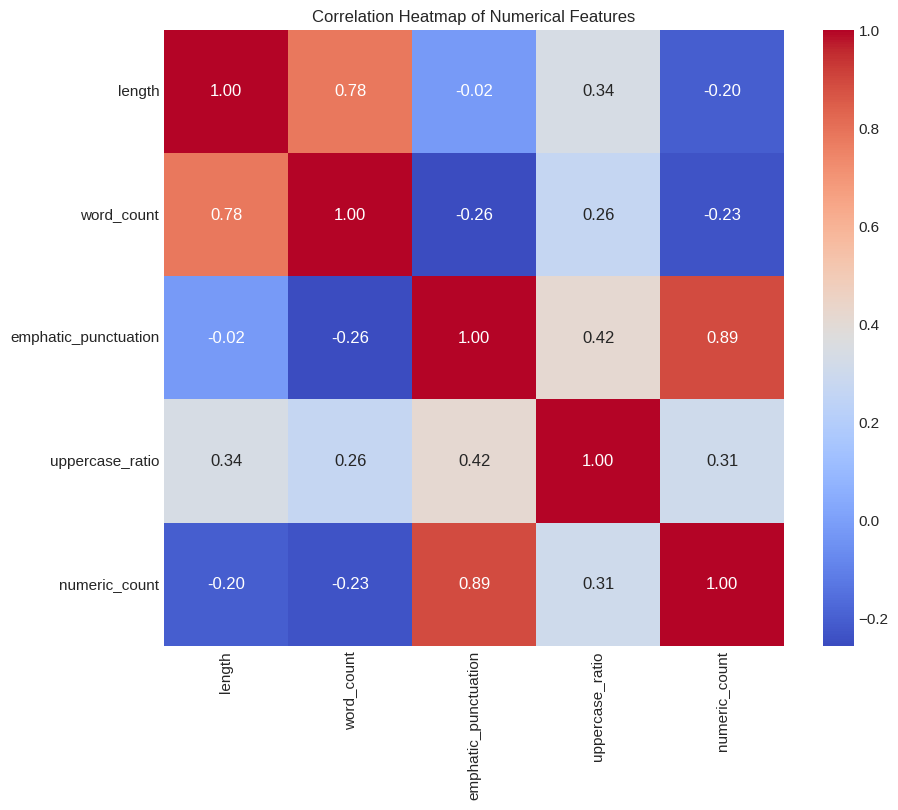

In [12]:
plt.figure(figsize=(10, 8))
# Select only numeric columns for correlation
corr_matrix = data[features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

### Observation: Correlation
The heatmap reveals how features relate to each other. For instance, `length` and `word_count` are naturally highly correlated. We might also see if `uppercase_ratio` correlates with `emphatic_punctuation`, suggesting a cluster of "aggressive" formatting features.

In [13]:
def show_wordcloud(data, title=None):
    text = str(data).replace("'", "")
    wordcloud = WordCloud(
        background_color='white',
        stopwords=None,
        max_words=200,
        max_font_size=40,
        scale=3,
        random_state=1
    ).generate(text)

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

#### Spam Word Cloud

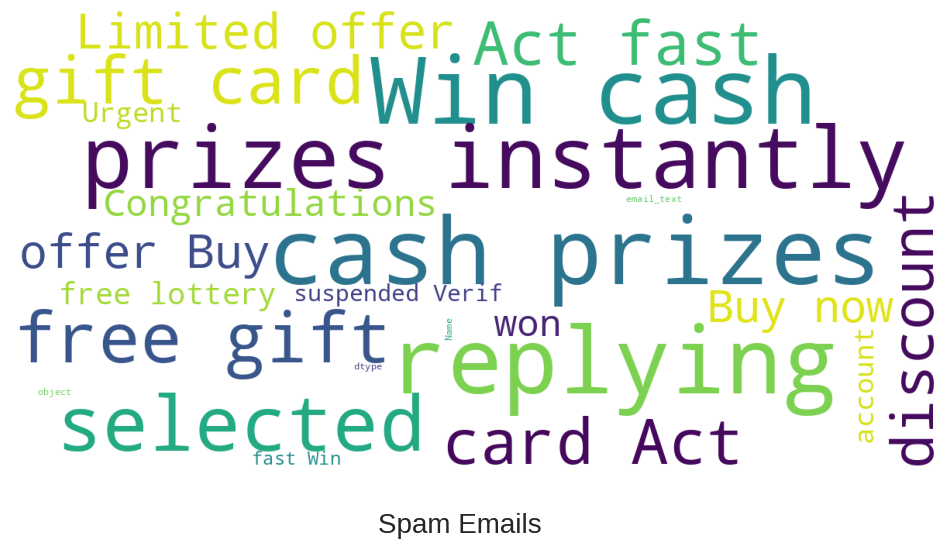

In [14]:
show_wordcloud(data[data['label'] == 'spam']['email_text'], title="Spam Emails")

#### Ham Word Cloud

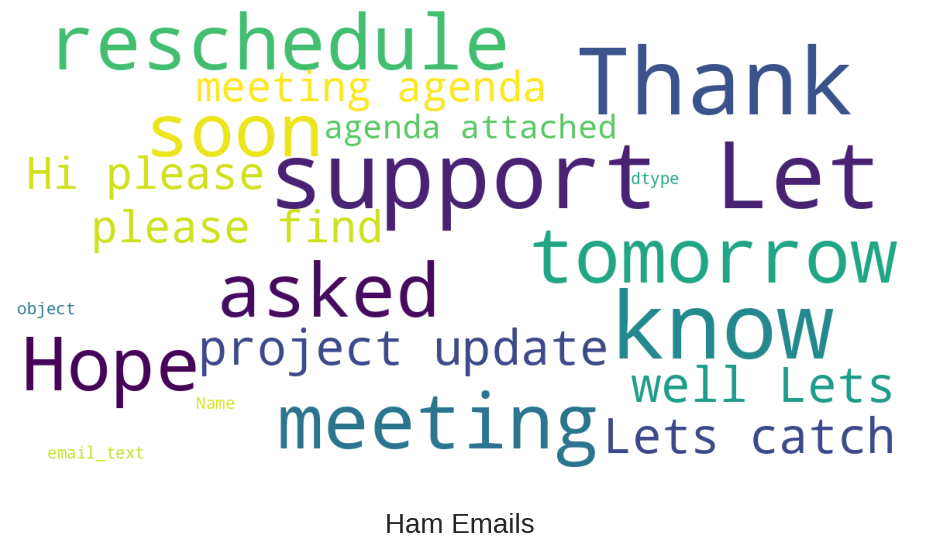

In [15]:
show_wordcloud(data[data['label'] == 'ham']['email_text'], title="Ham Emails")

### Observation: Word Clouds
- **Spam**: Dominated by words like "FREE", "WIN", "URGENT", "CASH", "PRIZE", "OFFER". The language is clearly sales-oriented and urgent.
- **Ham**: Contains more conversational and business-related terms like "meeting", "project", "attached", "support", "update".

Top 10 Bigrams - Spam


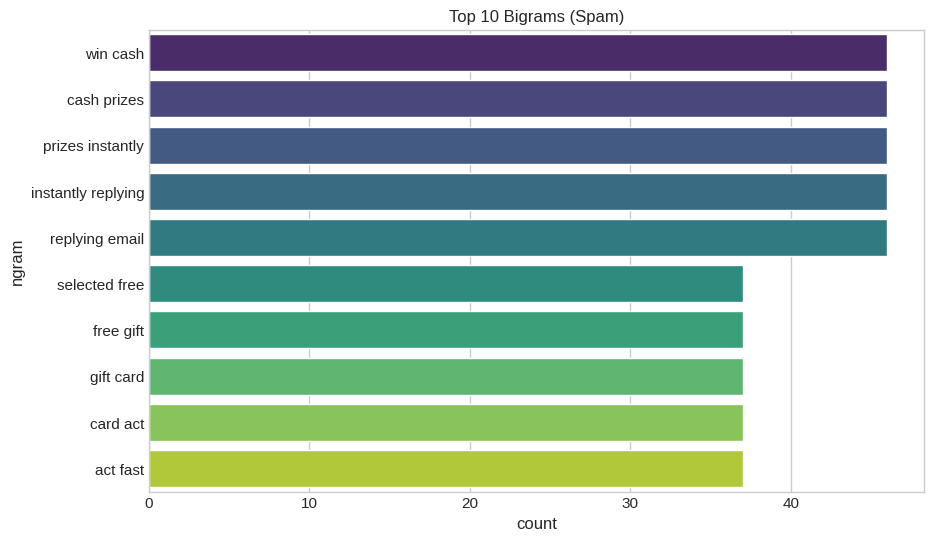

Top 10 Bigrams - Ham


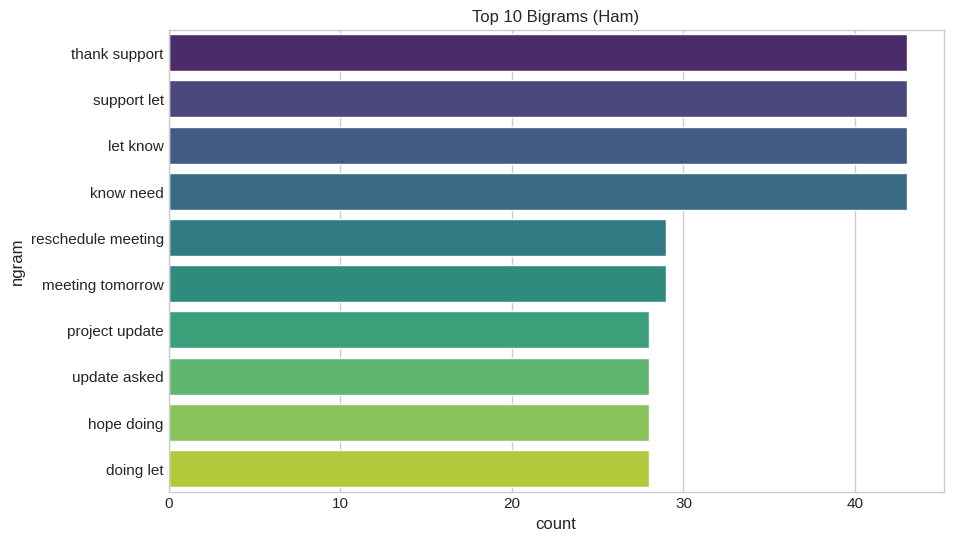

In [16]:
def plot_ngrams(text_series, n=2, title="N-Grams"):
    # Use stop_words='english' to remove common words only if helpful, but sometimes spam uses them.
    # For this, let's use standard english stop words.
    vec = CountVectorizer(ngram_range=(n, n), stop_words='english').fit(text_series)
    bag_of_words = vec.transform(text_series)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    common_words = words_freq[:10]
    df_ngram = pd.DataFrame(common_words, columns = ['ngram', 'count'])
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='count', y='ngram', data=df_ngram, palette='viridis', hue='ngram')
    plt.title(title)
    plt.show()

print("Top 10 Bigrams - Spam")
plot_ngrams(data[data['label'] == 'spam']['email_text'], n=2, title="Top 10 Bigrams (Spam)")

print("Top 10 Bigrams - Ham")
plot_ngrams(data[data['label'] == 'ham']['email_text'], n=2, title="Top 10 Bigrams (Ham)")

In [17]:
data.head()

,email_text,label,length,word_count,emphatic_punctuation,uppercase_ratio,numeric_count
0,Here is the project update you asked for.,ham,41,8,0,0.024390,0
1,Limited offer!!! Buy now and get 50% discount.,spam,46,8,3,0.043478,2
2,Win cash prizes instantly by replying to this ...,spam,52,9,0,0.019231,0
3,Urgent! Your account has been suspended. Verif...,spam,60,8,1,0.050000,0
4,"Hi, please find the meeting agenda attached.",ham,44,7,0,0.022727,0


In [18]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip()
    return text

In [19]:
data['clean_text'] = data['email_text'].apply(clean_text)
data.head()

,email_text,label,length,word_count,emphatic_punctuation,uppercase_ratio,numeric_count,clean_text
0,Here is the project update you asked for.,ham,41,8,0,0.024390,0,here is the project update you asked for
1,Limited offer!!! Buy now and get 50% discount.,spam,46,8,3,0.043478,2,limited offer buy now and get discount
2,Win cash prizes instantly by replying to this ...,spam,52,9,0,0.019231,0,win cash prizes instantly by replying to this ...
3,Urgent! Your account has been suspended. Verif...,spam,60,8,1,0.050000,0,urgent your account has been suspended verify ...
4,"Hi, please find the meeting agenda attached.",ham,44,7,0,0.022727,0,hi please find the meeting agenda attached


In [20]:
lbl_enc = LabelEncoder()
lbl_enc.fit(data['label'])
joblib.dump(lbl_enc, "label_encoder.joblib")

['label_encoder.joblib']

In [21]:
X = data['clean_text']
y = data['label']

In [22]:
loaded_enc = joblib.load("label_encoder.joblib")
y = loaded_enc.transform(y)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [24]:
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf.fit(X_train)
joblib.dump(tfidf, "tfidf.joblib")

['tfidf.joblib']

In [25]:
loaded_tfidf = joblib.load("tfidf.joblib")

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [26]:
def training_classification(X, y):
    rfc = RandomForestClassifier()
    abc = AdaBoostClassifier()
    gbc = GradientBoostingClassifier()
    etc = ExtraTreesClassifier()
    lgr = LogisticRegression()
    svc = SVC()
    mnb = MultinomialNB()
    xgb = XGBClassifier()
    lgb = LGBMClassifier(verbose=-100)
    cat = CatBoostClassifier(verbose=False)

    models = [rfc, abc, gbc, etc, lgr,
             svc, mnb, xgb, lgb, cat]

    names = ["Random Forest", "Ada Boost", "Gradient Boosting", "Extra Trees", "Logistic Regression",
            "SVC", "Naive Bayes", "XGBoost", "LightGBM", "Cat Boost"]

    scores = dict()
    for i in names:
        scores[i] = []

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    ik=0
    for train_idx, valid_idx in skf.split(X, y):
        ik+=1
        print(f"running : {ik} fold")
        for i, j in enumerate(names):
            #print(f"Running for model: {j}")
            x_train, x_valid = X[train_idx], X[valid_idx]
            y_train, y_valid = y[train_idx], y[valid_idx]
            
            models[i].fit(x_train, y_train)
            
            pred = models[i].predict(x_valid)
            scores[j].append(accuracy_score(pred, y_valid))


    return scores

In [27]:
scores = training_classification(X_train_tfidf, y_train)

running : 1 fold
running : 2 fold
running : 3 fold
running : 4 fold
running : 5 fold


In [28]:
scores

{'Random Forest': [1.0, 1.0, 1.0, 1.0, 1.0],
 'Ada Boost': [1.0, 1.0, 1.0, 1.0, 1.0],
 'Gradient Boosting': [1.0, 1.0, 1.0, 1.0, 1.0],
 'Extra Trees': [1.0, 1.0, 1.0, 1.0, 1.0],
 'Logistic Regression': [1.0, 1.0, 1.0, 1.0, 1.0],
 'SVC': [1.0, 1.0, 1.0, 1.0, 1.0],
 'Naive Bayes': [1.0, 1.0, 1.0, 1.0, 1.0],
 'XGBoost': [1.0, 1.0, 1.0, 1.0, 1.0],
 'LightGBM': [1.0,
  0.8823529411764706,
  0.9607843137254902,
  0.9019607843137255,
  0.9411764705882353],
 'Cat Boost': [1.0, 1.0, 1.0, 1.0, 1.0]}

In [29]:
clf = LogisticRegression()
clf.fit(X_train_tfidf, y_train)

LogisticRegression()

In [30]:
print(f"Accuracy: {accuracy_score(y_test, clf.predict(X_test_tfidf))}")

Accuracy: 1.0


In [31]:
print(f"ROC AUC score: {roc_auc_score(y_test, clf.predict(X_test_tfidf))}")

ROC AUC score: 1.0


In [32]:
print(f"Classification report")
print(classification_report(y_test, clf.predict(X_test_tfidf)))

Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        34

    accuracy                           1.00        64
   macro avg       1.00      1.00      1.00        64
weighted avg       1.00      1.00      1.00        64

